<a href="https://colab.research.google.com/github/Faradayxx/202155202019-Dandy_Fajar_Febrian/blob/main/Perbandingan_Algoritma_RandomForest_VS_LinearRegression_dalam_Memprediksi_Harga_Laptop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install  pycountry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 11.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

In [5]:
# Import library
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Import library
from google.colab import files

# Menggunakan widget upload file
uploaded = files.upload()

Saving Laptop Sales Per Day.xlsx to Laptop Sales Per Day.xlsx


In [7]:
!pip install pandas

In [8]:
# Ambil nama file yang diunggah
file_name = list(uploaded.keys())[0]

# Baca file XLSX
data = pd.read_excel(file_name)

# Tentukan nama file CSV yang akan disimpan
csv_file_name = file_name.replace('.xlsx', '.csv')

# Simpan sebagai file CSV
data.to_csv(csv_file_name, index=False)

print(f"File {file_name} berhasil diubah menjadi {csv_file_name}")

File Laptop Sales Per Day.xlsx berhasil diubah menjadi Laptop Sales Per Day.csv


In [9]:
df = pd.read_csv("/content/Laptop Sales Per Day.csv")

In [10]:
print(df)

     Company                              Product            TypeName  Inches  \
0      Apple                          MacBook Pro           Ultrabook    13.3   
1      Apple                          Macbook Air           Ultrabook    13.3   
2         HP                               250 G6            Notebook    15.6   
3      Apple                                                Ultrabook    15.4   
4      Apple                          MacBook Pro           Ultrabook    13.3   
...      ...                                  ...                 ...     ...   
1298  Lenovo                       Yoga 500-14ISK  2 in 1 Convertible    14.0   
1299  Lenovo                       Yoga 900-13ISK  2 in 1 Convertible    13.3   
1300  Lenovo                   IdeaPad 100S-14IBR            Notebook    14.0   
1301      HP  15-AC110nv (i7-6500U/6GB/1TB/Radeon            Notebook    15.6   
1302    Asus  X553SA-XX031T (N3050/4GB/500GB/W10)            Notebook    15.6   

                           

In [11]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: #78c679' if v else '' for v in is_max]

# Replace 'Column1', 'Column2' with the actual column names you want to style
styled_df = df.head().style.apply(highlight_max, subset=['Total Sales per Day (euros)', 'Weight', 'Price_euros', 'Inches', 'Ram (GB)'])

styled_df

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram (GB),Memory,Gpu,OpSys,Weight,Price_euros,Total Sales per Day (euros)
0,Apple,MacBook Pro,Ultrabook,13.300000,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.370000,1339.690000,2679.380000
1,Apple,Macbook Air,Ultrabook,13.300000,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.340000,898.940000,898.940000
2,HP,250 G6,Notebook,15.600000,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.860000,575.000000,1150.000000
3,Apple,,Ultrabook,15.400000,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.830000,2537.450000,7612.350000
4,Apple,MacBook Pro,Ultrabook,13.300000,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.370000,1803.600000,3607.200000


In [12]:
def null_count(df):
    return pd.DataFrame({'features': df.columns,
                'dtypes': df.dtypes.values,
                'NaN count': df.isnull().sum().values,
                'NaN percentage': df.isnull().sum().values/df.shape[0]}).style.background_gradient(cmap='jet',low=0.1,high=0.01)
null_count(df)

,features,dtypes,NaN count,NaN percentage
0,Company,object,0,0.000000
1,Product,object,0,0.000000
2,TypeName,object,0,0.000000
3,Inches,float64,0,0.000000
4,ScreenResolution,object,0,0.000000
5,Cpu,object,0,0.000000
6,Ram (GB),int64,0,0.000000
7,Memory,object,0,0.000000
8,Gpu,object,0,0.000000
9,OpSys,object,0,0.000000


In [13]:
df.iloc[:, :].describe().T.sort_values(by='std', ascending=False) \
    .style.background_gradient(cmap='GnBu') \
    .bar(subset=["max"], color='#BB0000') \
    .bar(subset=["mean"], color='green')

,count,mean,std,min,25%,50%,75%,max
Total Sales per Day (euros),1303.000000,2432.426048,1957.498774,224.000000,1138.000000,1900.000000,3158.000000,19875.000000
Price_euros,1303.000000,1123.686992,699.009043,174.000000,599.000000,977.000000,1487.880000,6099.000000
Ram (GB),1303.000000,8.382195,5.084665,2.000000,4.000000,8.000000,8.000000,64.000000
Inches,1303.000000,15.017191,1.426304,10.100000,14.000000,15.600000,15.600000,18.400000
Weight,1303.000000,2.038734,0.665475,0.690000,1.500000,2.040000,2.300000,4.700000


<Axes: >

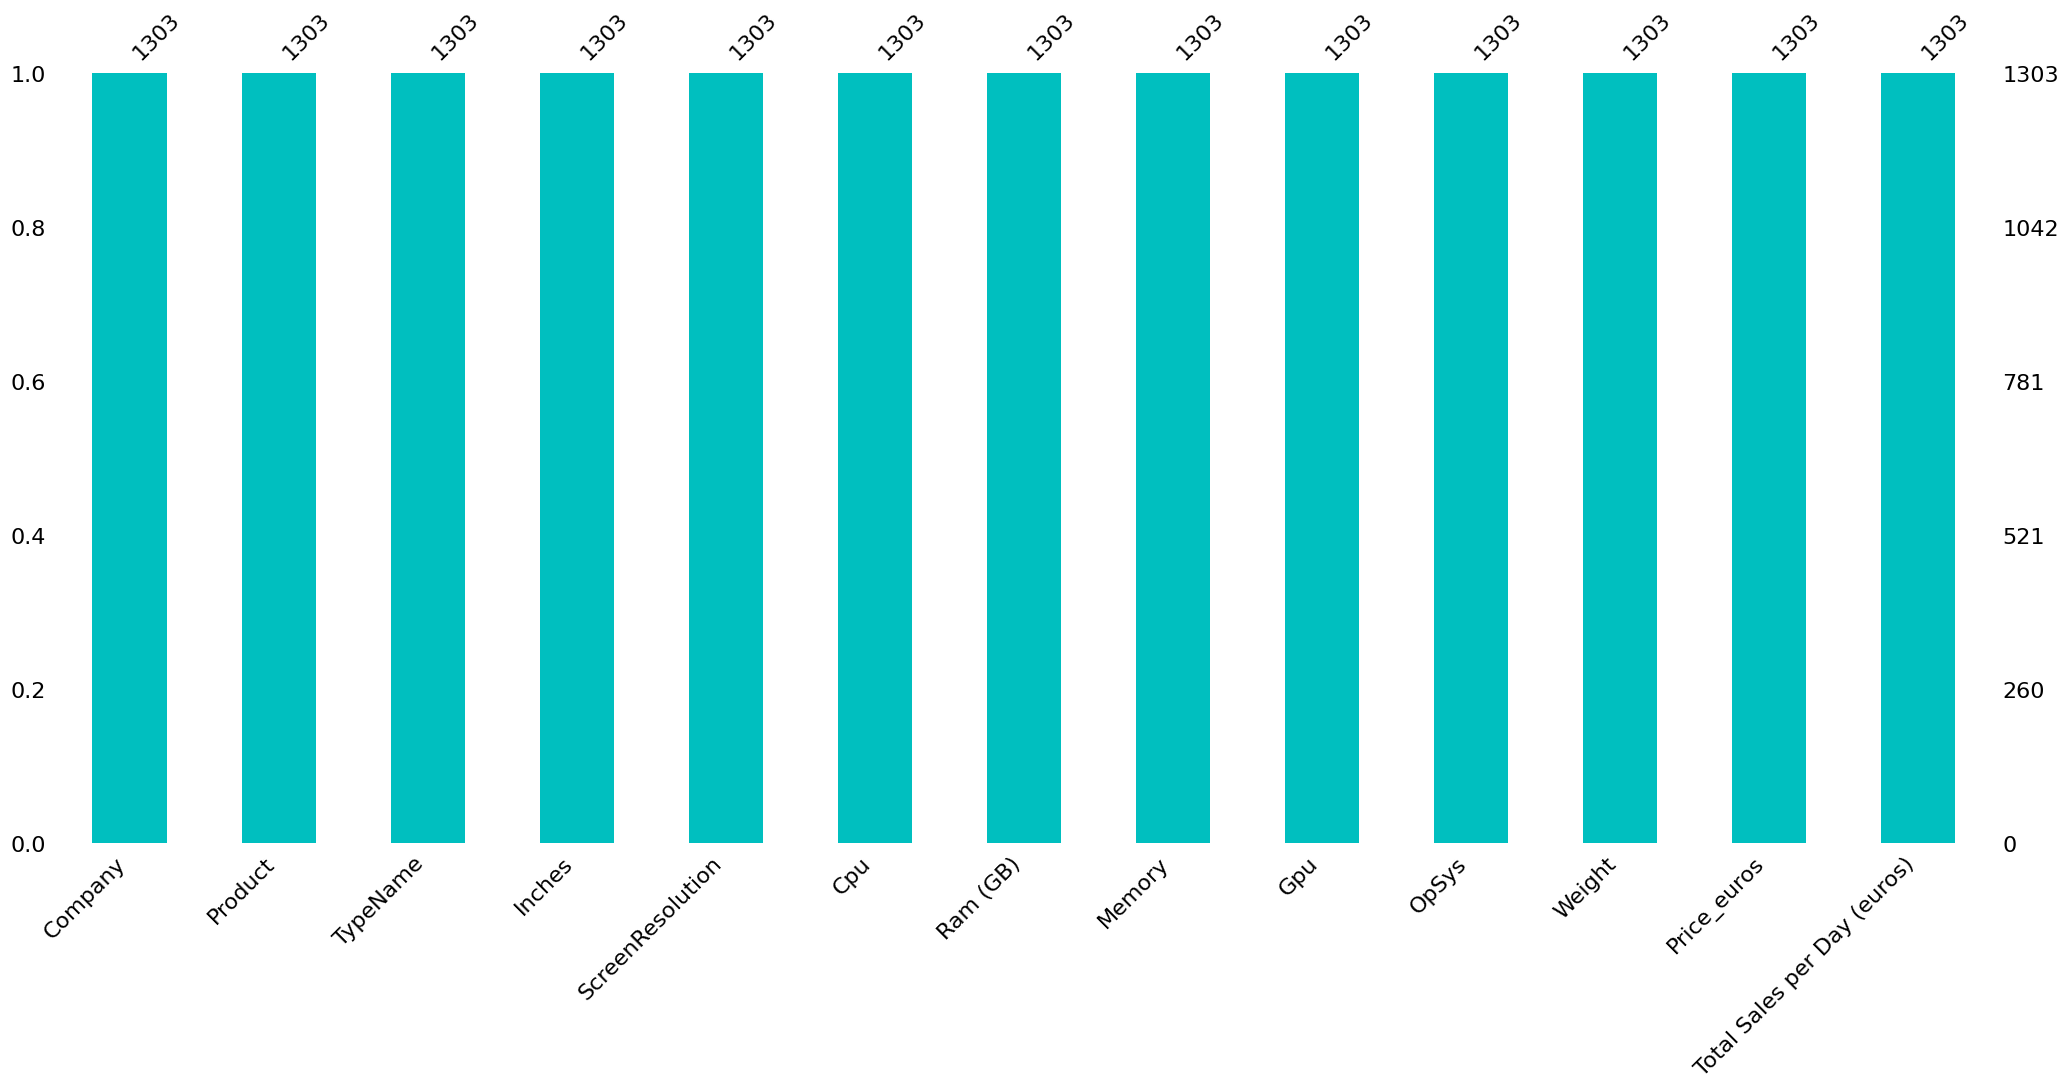

In [14]:
msno.bar(df, color = 'c')

In [15]:
print("Number of duplicates: " + str(df.duplicated().sum()))

Number of duplicates: 8


In [16]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

Company: 19 distinct values
Product: 618 distinct values
TypeName: 6 distinct values
Inches: 18 distinct values
ScreenResolution: 40 distinct values
Cpu: 118 distinct values
Ram (GB): 9 distinct values
Memory: 39 distinct values
Gpu: 110 distinct values
OpSys: 9 distinct values
Weight: 171 distinct values
Price_euros: 791 distinct values
Total Sales per Day (euros): 993 distinct values


In [17]:
def clean_data(df):
    # Convert 'Total Sales per Day (euros)' column to numeric, handling non-numeric values
    df['Total Sales per Day (euros)'] = pd.to_numeric(df['Total Sales per Day (euros)'], errors='coerce')

    # Example: Fill missing values in 'Total Sales per Day (euros)' with the mean
    df['Total Sales per Day (euros)'].fillna(df['Total Sales per Day (euros)'].mean(), inplace=True)

    return df

df_clean = clean_data(df.copy())

In [18]:
df1 = df_clean.copy()

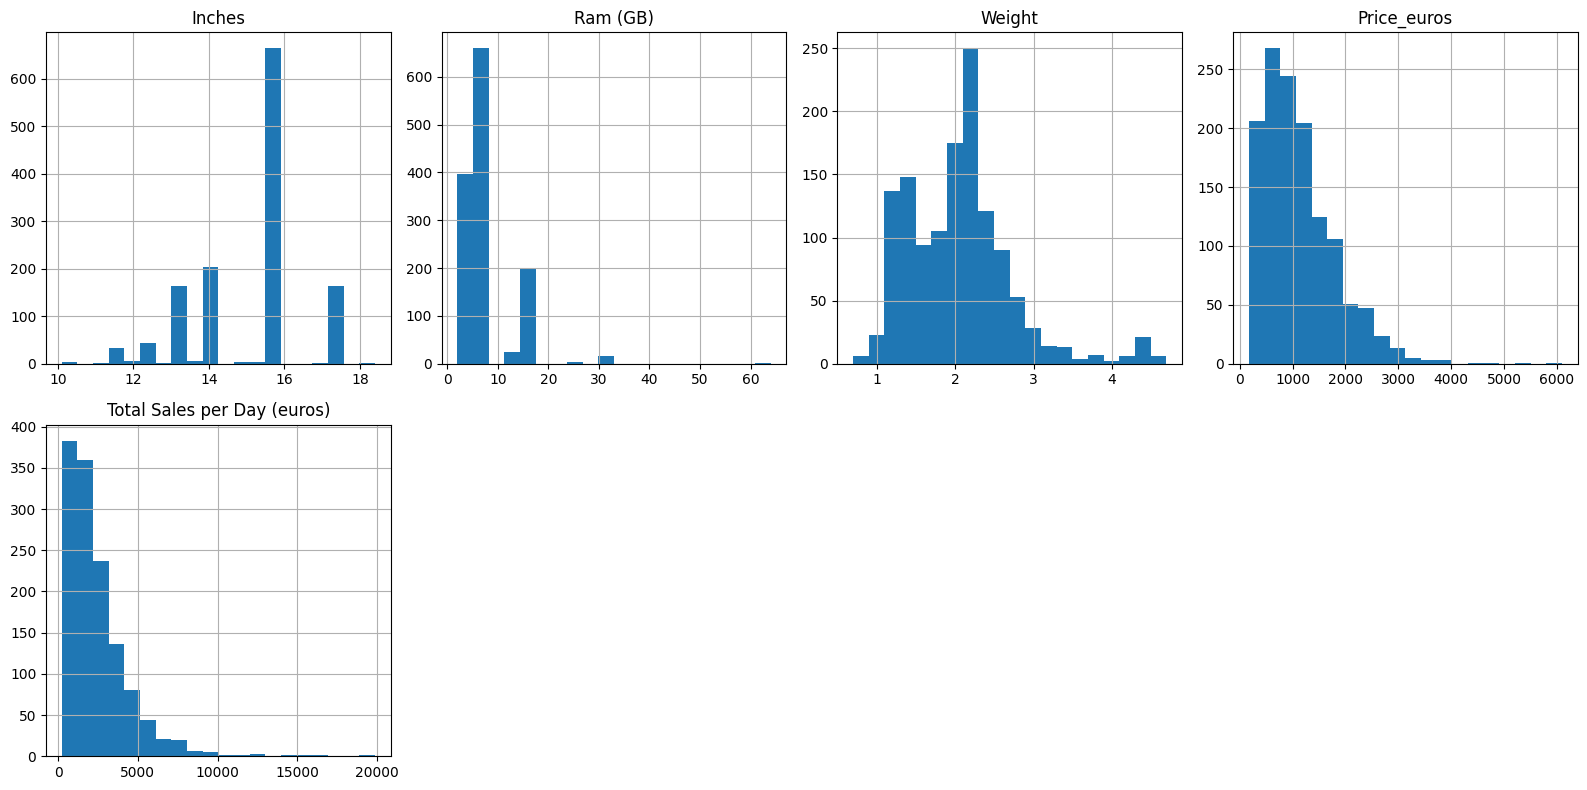

In [19]:
df1.hist(layout=(2, 4), bins=20, figsize=(16, 8))
plt.tight_layout()
plt.show()

In [20]:
df2 = df1.copy()

In [21]:
df2 = df2.dropna()

In [22]:
X = df2[['Price_euros','Ram (GB)', 'Inches', 'Weight']]
y = df2['Total Sales per Day (euros)']

In [23]:
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

In [24]:
X_scaled_df = pd.DataFrame(X_scaled)

X_scaled_df.describe().T.style.background_gradient(axis=0, cmap='Set2')

,count,mean,std,min,25%,50%,75%,max
0,1303.000000,0.000000,1.000384,-1.359141,-0.750904,-0.209930,0.521213,7.120399
1,1303.000000,-0.000000,1.000384,-1.255667,-0.862176,-0.075195,-0.075195,10.942543
2,1303.000000,0.000000,1.000384,-3.448829,-0.713439,0.408772,0.408772,2.372641
3,1303.000000,-0.000000,1.000384,-2.027503,-0.809859,0.001904,0.392752,4.000586


In [25]:
decom = PCA(svd_solver='auto')
X_pca = decom.fit_transform(X_scaled)

In [26]:
ex_var = np.cumsum(np.round(decom.explained_variance_ratio_, 2) * 100)

<Axes: >

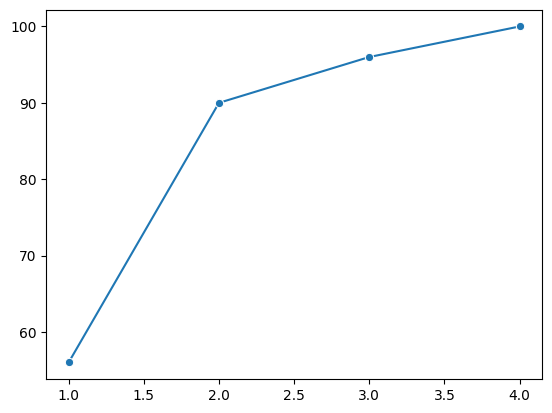

In [27]:
sns.lineplot(y=ex_var, x=np.arange(1, len(ex_var) + 1), marker='o')

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [29]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_linear = linear_reg.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)

In [30]:
random_forest_reg = RandomForestRegressor()
random_forest_reg.fit(X_train, y_train)
y_pred_forest = random_forest_reg.predict(X_test)
mse_forest = mean_squared_error(y_test, y_pred_forest)

In [31]:
results_df3 = pd.DataFrame(index=['Linear Regression', 'Random Forest'])

results_df3['Mean Squared Error'] = [
    mse_linear,
    mse_forest
]

In [32]:
results_df3['R-squared'] = [
    r2_score(y_test, y_pred_linear),
    r2_score(y_test, y_pred_forest)
]

print(results_df3)

                   Mean Squared Error  R-squared
Linear Regression        1.204223e+06   0.646298
Random Forest            1.285748e+06   0.622352


In [33]:
!pip install optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00


In [34]:
optuna.logging.disable_default_handler() # Disable Optuna's default logging

In [35]:
def objective(trial):
    alpha = trial.suggest_loguniform('alpha', 0.1, 100)
    linear_model = LinearRegression() # Use LinearRegression
    linear_model.fit(X_train, y_train)
    y_pred = linear_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

<ipython-input-35-e8c5a9de5e40>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 100)
<ipython-input-35-e8c5a9de5e40>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 100)
<ipython-input-35-e8c5a9de5e40>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 100)
<ipython-input-35-e8c5a9de5e40>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will 

In [36]:
optuna.logging.enable_default_handler()

In [37]:
best_alpha_optuna = study.best_params['alpha']
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_best = linear_model.predict(X_test)
mse_best_model = mean_squared_error(y_test, y_pred_best)

print(f'Mean Squared Error for the Best Linear Regression Model: {mse_best_model}')
print(f'Number of finished trials: {len(study.trials)}')
print(f'Best trial:\n{study.best_trial}')

Mean Squared Error for the Best Linear Regression Model: 1204223.1071762096
Number of finished trials: 100
Best trial:
FrozenTrial(number=0, state=TrialState.COMPLETE, values=[1204223.1071762096], datetime_start=datetime.datetime(2024, 7, 21, 14, 40, 5, 805230), datetime_complete=datetime.datetime(2024, 7, 21, 14, 40, 5, 811256), params={'alpha': 0.8899621642985259}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'alpha': FloatDistribution(high=100.0, log=True, low=0.1, step=None)}, trial_id=0, value=None)


In [38]:
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_best})
print(result_df.head(5))

      Actual    Predicted
479   3344.0  3553.255358
1022  1149.0  2546.972660
298    998.0  1070.836387
1265   899.0  1947.375013
774   1244.0  2454.764837


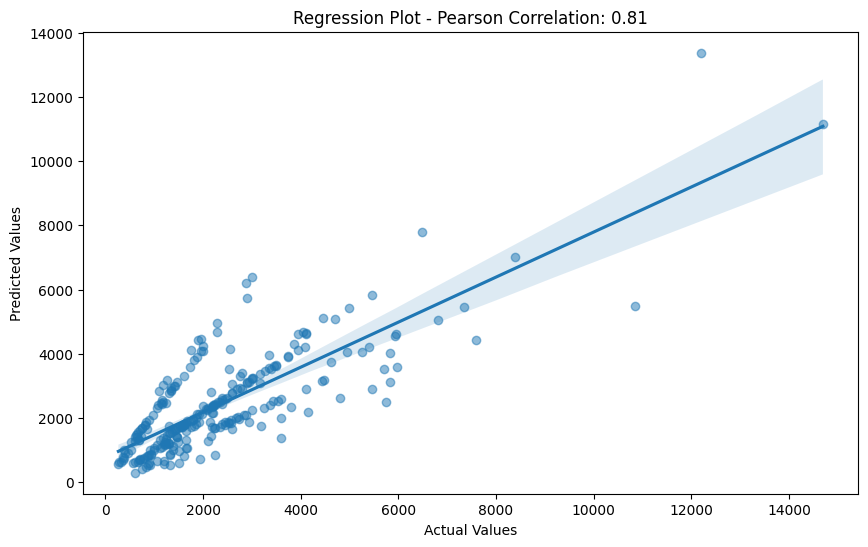

In [39]:
correlation, _ = pearsonr(y_test, y_pred_best)

plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred_best, scatter_kws={'alpha': 0.5})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Regression Plot - Pearson Correlation: {correlation:.2f}')
plt.show()

Feature Importance:
       Feature  Coefficient  AbsCoefficient
1     Ram (GB)   960.335967      960.335967
0  Price_euros   712.493436      712.493436
2       Inches  -676.193939      676.193939
3       Weight  -108.028847      108.028847


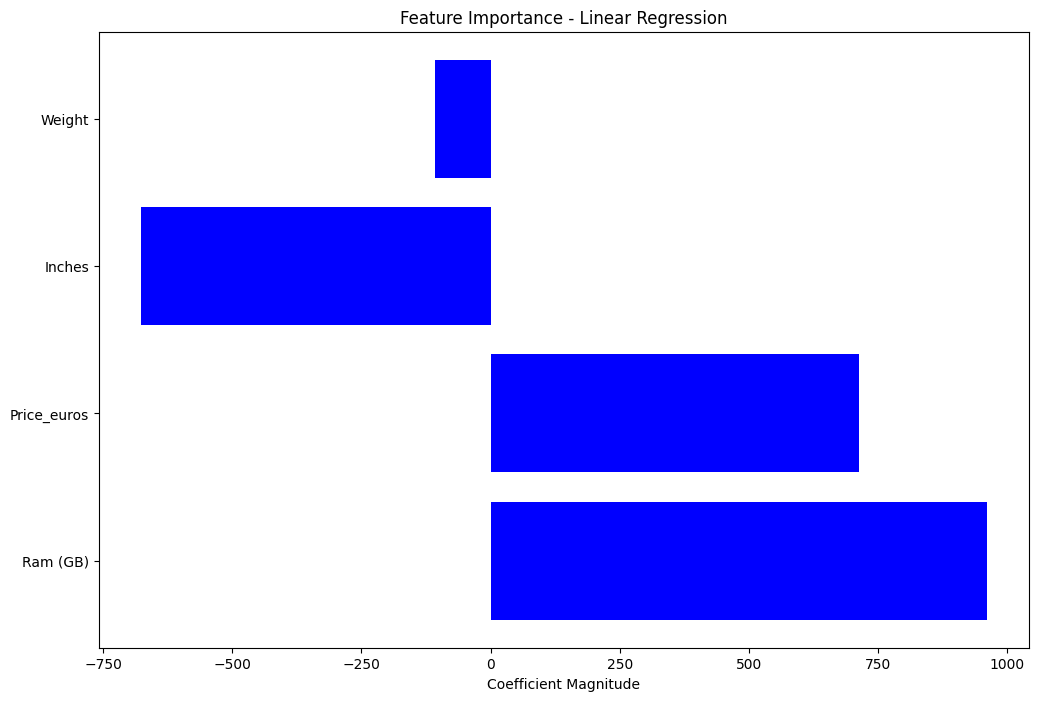

In [40]:
coefficients_best_model = linear_model.coef_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients_best_model})
feature_importance_df['AbsCoefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='AbsCoefficient', ascending=False)

print("Feature Importance:")
print(feature_importance_df)


plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Coefficient'], color='blue')
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Importance - Linear Regression')
plt.show()

**PENGUJIAN EVALUASI MODEL REGRESI**

Cross-validated MSE: 1204223.1071762096


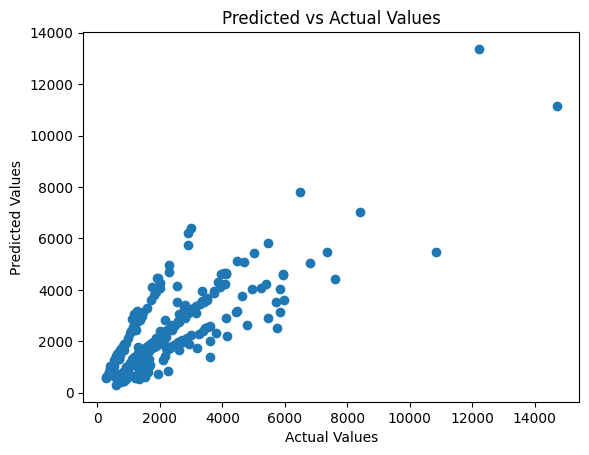

In [43]:
linear_model = LinearRegression() # Use LinearRegression
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Cross-validated MSE: {mse}")

# Visualize the results
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

In [ ]:
linear_model = LinearRegression() # Use LinearRegression
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

In [44]:
y_test.iloc[0]

3344.0

**HARGA ASLI : 3344.0**

In [50]:
linear_model.predict(X_test)[0]

3553.2553582120026

**HASIL HARGA PREDIKSI MENGGUNAKAN LINEAR REGRESSION: 3553**

In [49]:
random_forest_reg.predict(X_test)[0]

4265.897199999999

**HASIL HARGA PREDIKSI MENGGUNAKAN RANDOM FOREST: 4265**